In [3]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing_extensions import Literal

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage

from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.func import entrypoint, task

from IPython.display import Image, display
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langchain.agents import initialize_agent, AgentType
from langchain.agents import Tool


from dotenv import load_dotenv
_ = load_dotenv()

In [4]:
llm = ChatOpenAI(model="gpt-4")

In [5]:
# 2. Load and embed document
loader = PyPDFLoader("bcbs_brochure.pdf")
docs = loader.load()

embeddings = OpenAIEmbeddings()
vectorstore = Chroma.from_documents(docs, embeddings)  # No persist directory = in-memory
retriever = vectorstore.as_retriever()

In [6]:
# Define tools
search = DuckDuckGoSearchRun()

rag = create_retriever_tool(
    retriever=retriever,
    name="document_rag",
    description=""" Answers questions using the content of bcbs_procure.pdf. 
    It contains information about Blue Cross Blue Shield healthcare plans.
    """
)

# Augment the LLM with tools
tools = [search, rag]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [7]:
llm_with_tools.invoke('What tools do you have, what document can you read with document retrieval')

AIMessage(content='I have multiple capabilities that you can utilize. These include:\n\n1. DuckDuckGo Search: This is a tool that allows me to make searches on the internet. You can use this to get the latest information or answer questions on a wide array of topics.\n\n2. Document Retrieval: Currently, I can use document retrieval to access a specific PDF document called "bcbs_procure.pdf." This document contains extensive information on Blue Cross Blue Shield healthcare plans. I can refer to this document to answer detailed questions about these healthcare plans.\n\nPlease note that over time, additional capabilities may be added to extend the types of documents or resources I can access and retrieve information from.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 137, 'prompt_tokens': 140, 'total_tokens': 277, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_t

In [8]:

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant skilled at saying what day it is."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()


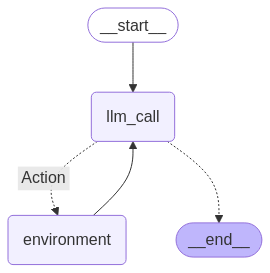

In [9]:
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [10]:
# Invoke
messages = [HumanMessage(content="How much is a blue cross blue shield primary care copay? Make a bar graph.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

How much is a blue cross blue shield primary care copay? Make a bar graph.
================================== Ai Message ==================================
Tool Calls:
  document_rag (call_cqBN7uRyN2oRTqfuSvMwVSTs)
 Call ID: call_cqBN7uRyN2oRTqfuSvMwVSTs
  Args:
    query: blue cross blue shield primary care copay
================================= Tool Message =================================

27
Description
Coverage Level
Catastrophic 9200  
3 free PCP visits
BRONZE  
8900
BRONZE  
7400 HSA -  
Custom Drug Benefit1
BRONZE  
3800
Plan Availability
my Blue Access  
Major Events PPO  
Catastrophic 9200 -  
3 free PCP visits
my Blue Access  
PPO Bronze 8900
my Blue Access PPO  
Bronze 7400 HSA -  
Custom Drug Benefit1
my Blue Access  
PPO Bronze 3800
In-Network Deductible Individual: $9,200 
Family: $18,400
Individual: $8,900 
Family: $17,800
Individual: $7,400 
Family: $14,800
Individual: $3,800  
Family: 